# An Agent Based Classroom Seating Model

In [1]:
''' Set up this document and import libraries '''
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib notebook
rcParams['figure.figsize'] = (6, 4)

## Introduction



## Setting up the Environment

To begin, we must define the characteristics of the model's environment, that is the layout of the classroom. This is setup with two main variables:

* The number of rows, `num_rows`
* A list of blocks sizes, `blocks`, where each element describes the width of a seating section, which are separated by verticle aisles. Can be 0.
 
Note the number of rows also counts for any horizontal aisles, which there is asssumed to be one at the front of the classrom. This can be specfied in the `aisles_y` variable. This however does not affect the agents' movement, but it is merely an asthetic feature when plotting.

In [2]:
''' Define the Classroom shape '''
num_rows = 14
blocks = [3, 14, 0]
aisles_y = [0]

Next, it possible to score the seats in the classroom a desireability value, from the range [0, 1]. That is, seats with a score 0 are avoided by the students (e.g. the front rows seats), and seats with a score 1 are highly sought after (e.g. the seats in the middle that have a good view). These values are stored in a `numpy` array named `pos_utilities`. The shape of the array does not necessarily have to include the aisles (the model can fill these in). This should be indexed as (Column, Row) since we are dealing with (x, y) positional data. Also note the front row of the class is at index 0.

This array can be generated in a varienty of ways, such as with some 2D distribution, but here we will keep it simple and split the classroom into sections and manually define some scores.

<IPython.core.display.Javascript object>


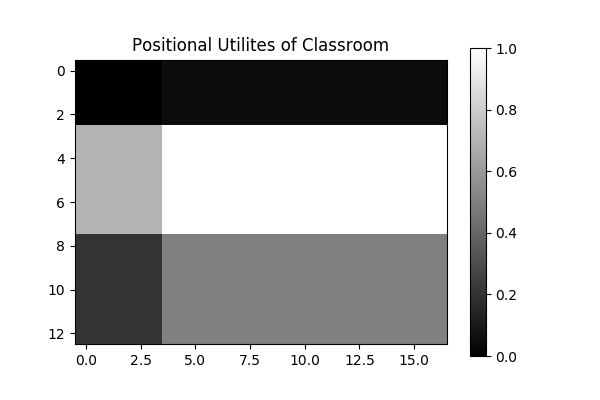

In [11]:
''' Define the positional utilities of the classroom '''
pos_utilities = np.ones((sum(blocks), num_rows-1))

# use the blocks to calculate the aisles' locations 
# and use them to define sections
aisles = np.cumsum(blocks)

# first three rows very undesirable
pos_utilities[aisles[0]+1:, 0:3] *= 0.05
pos_utilities[0:aisles[0]+1, 0:3] *= 0.0

# back five rows somewhat desirable
pos_utilities[aisles[0]+1:, -5:] *= 0.5
pos_utilities[0:aisles[0]+1, -5:] *= 0.2

# middle section to the left also quite desirable
pos_utilities[0:aisles[0]+1, 3:-5] *= 0.7

''' Plot this utility map '''
plt.figure()
plt.imshow(pos_utilities.T, cmap='gray')
plt.title('Positional Utilites of Classroom')
plt.colorbar()
plt.show()

Finally, these parameters are stored in an instance of the `ClassroomDesign` class, for reuse and referencing later.

In [13]:
from model import ClassroomDesign

''' Create the classroom object '''
classroom = ClassroomDesign(blocks=blocks,
                            num_rows=num_rows,
                            aisles_y=aisles_y,
                            pos_utilities=pos_utilities)

### The Agents

The students in the simulation have numerous perameters that facilitate dynamic behaviour. 

First, each student has a *sociability* factor that determines how comfortable they are sitting next to someone that they do not know. Negative values indicate social aversion (e.g. rather sit alone), 0 indiffernece, and positive values for a sociable student, willing to meet new people. (The exact range of these values does not matter, since they will be normalised in the utility calulations).

To set this in the model, we must generate a list of sociabilities to use, one for each student. This can be generated in a few ways, e.g. sampled from a suitable probability distribution (e.g. Uniform, Normal, Cauchy etc). For this example however, we will instead draw from a distribution generated from some real, collected data on this behaviour.

<IPython.core.display.Javascript object>


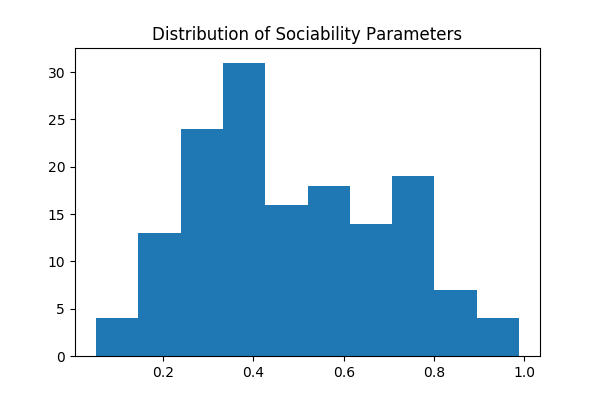

In [14]:
from data_processing.process_form import agent_sociability_gen

''' Set the students sociabilities '''
class_size = 150
sociability_generator = agent_sociability_gen()
sociability_sequence = [next(sociability_generator) for _ in range(class_size)]

plt.figure()
plt.hist(sociability_sequence)
plt.title('Distribution of Sociability Parameters')
plt.show()

Next, we must setup the *social network* of the class. Students are likely to sit next to other friends in the room, provided it is not too difficult to reach them. This network is a unweighted, undirected graph where each edge indicates a mutual friendship, and this is stored as `social_network`, an NxN matrix. Students are likely to sit next to other friends in the room, provided it is not too difficult to reach them.

Again, there are a variety of possibilities to generate this social graph for experiments. Just like the sociabilities, we can use real data that we also collected. However, for simplicity we will use the library `networkx` to create an Erdős-Renyi graph, which has been shown to accurately model real networks

In [15]:
import networkx as nx

''' Set the social network '''
er_graph = nx.erdos_renyi_graph(class_size, 0.2)
social_network = nx.to_numpy_matrix(er_graph)

####################
# To use the real data, uncomment the following:

# from data_processing.process_form import agent_friends_gen
# from social.network import walts_graph
# friendship_generator = agent_friends_gen()
# degree_sequence = [next(friendship_generator) for _ in range(class_size)]
# social_network = walts_graph(degree_sequence, plot=False)[0]

### Model Setup

The model we have created is essentially a discrete choice model, and so a crucial component of the model is the *utility function*. The utility of a seat $\vec{x}_i$ for student $i$ takes the form:

$$
\begin{equation}
u_i(\vec{x}_i) = \beta_1 f_i + \beta_2 s_i + \beta_3 p_i + \beta_4 a_i
\end{equation}
$$

A full description of how this utility is calculated can be found in our paper *An Agent-Based Model of Classroom Seating Behaviour* (LINK). For a simulation run, we must define the coefficients of this function, namely the $\beta$s. This is stored as an ordered list `coeffs`. Note that while the model requires that each $\beta$ is in the range (0, 1) and they must total 1, the model will automatically normalise any set of coefficients to meet these requirements. As expected, the values of these coefficients have a dramatic impact on the model's dynamics, and is the center of the study.

In [16]:
''' Define the utility coefficients '''
coefs = [
    0.3,   # positional utility
    1,     # friendship utility
    0,     # sociability 
    1      # accessability
]

Now that all the components have been set up, we can finally initialise the model.

In [17]:
from model import ClassroomModel

''' Initialise the model '''
classroom_model = ClassroomModel(classroom_design=classroom,
                                 coefs=coefs,
                                 social_network=social_network,
                                 seed=1)

We can observe the model as it is now with the model's built in `plot()` function.

<IPython.core.display.Javascript object>


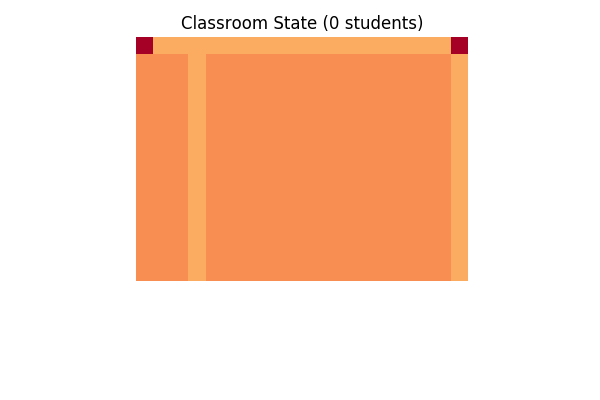

In [18]:
%matplotlib notebook
fig, ax = plt.subplots()
classroom_model.plot(fig, ax, interactive=True)

In [10]:
classroom_model.classroom.pos_utilities

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 

### Analysis